In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from collections import Counter
from datetime import date, datetime

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.model_selection import GridSearchCV  -- can be rather slower as per https://github.com/scikit-learn/scikit-learn/issues/9619
from sklearn.grid_search import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

from scipy import sparse

# pip install wordcloud
from wordcloud import WordCloud



%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# functions required to perform basic transformations
# these transformations can be safely applied to all the data set (inc validation)
# because they only take into consideration the values of the current row

# function to translate gender into 
def get_gender(_input):
    if 'Female' in _input:
        return 'F'
    elif 'Male' in _input:
        return 'M'
    else:
        return 'U'

# function that returns 1 if animal was operated; 0 otherwise
def is_operated(_input):    
    return int(_input.split()[0] in ['Neutered', 'Spayed'])   

# function that normalises age of animal in years
def get_age_in_years(_input):
    age = 0.0
    age_list = _input.split()
    if "year" in age_list[1]:
        age = float(age_list[0])
    elif "month" in age_list[1]:
        age = float(age_list[0]) / 12.0
    elif "week" in age_list[1]:
        age = float(age_list[0]) / 52.0
    else:
        # if less than 1 week, default to 1 week
        age = 1.0 / 52.0
    return round(age, 3)

def get_age_in_days(_input):
    return get_age_in_years(_input) * 365

# Transform ages to categoris as follows:
# 1 = neonatal; 2 = infant; 3 = child; 4 = adolescent; 5 = young_adult; 6 = mature_adult; 7 = old
# These categories are based on rate that animal ages w.r.t. human years and the stages of human development
# https://www.ajdesigner.com/fl_cat_age/cat_age.php; https://pets.webmd.com/dogs/how-to-calculate-your-dogs-age
def get_age_in_labels(_input):
    age_label = 0
    age_list = _input.split()
    age = int(age_list[0])
    if "year" in age_list[1]:
        # 
        options = [4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7]
        age = age - 1 if age < 11 else 10
        age_label = options[age]        
    elif "month" in age_list[1]:
        options = [2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
        age_label = options[age-1]
    elif "week" in age_list[1]:        
        age_label = 1
    else:
        # if less than 1 week, default to 1 week
        age_label = 1
    return age_label

# Adopt Etienne's age brackets
def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

# this function returns purity category: "pure", "mixed", "cross"
# depending on whether breed string features just the animal breed, the word "mix" or a fwd-slash
def get_breed_purity(_input):
    breed_purity = ""
    if "/" in _input:
        breed_purity = "mix"
    elif "Mix" in _input:
        breed_purity = "mix"
    else:
        breed_purity = "pure"
    return breed_purity

# code to determine season from: https://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(txstamp):
    if isinstance(txstamp, datetime):
        txstamp = txstamp.date()
    txstamp = txstamp.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= txstamp <= end)

def get_hour(txstamp):
    hr = int(txstamp.hour + round(txstamp.minute/60.0))
    return (0 if (hr == 24) else hr)

def get_day_segment(txstamp):
    return int(txstamp.hour/3)

def get_sine_transformation(value, max_value):
    return np.sin(2 * np.pi * (value / max_value))

def get_cosine_transformation(value, max_value):
    return np.cos(2 * np.pi * (value / max_value))

In [3]:
def extract_basic_features(df):

    # only 1 case of unknown sex
    #df[df["SexuponOutcome"].isnull() == True]
    # only 18 cases of unknown age
    #len(df[df["AgeuponOutcome"].isnull() == True])
    # remove null cases 

    # remove null ages
    df = df[~df['AgeuponOutcome'].isnull()]
    df = df[~df['SexuponOutcome'].isnull()]
    #print df.isnull().any()

    # there are 22 cases where Age is 0 years; the distribution of outcomes (compared to the cases where age is known)
    # best would be to remove these from the set too
    #print df[(df.AgeuponOutcome == '0 years')]["OutcomeType"].value_counts()
    #df.loc[df.AgeuponOutcome == '0 years', 'AgeuponOutcome'] = "1 week"
    df = df[~(df.AgeuponOutcome == '0 years')]
    df["HasName"] = (~df.loc[:,"Name"].isnull()).apply(lambda x: int(x))
    df["Neutered"] = df["SexuponOutcome"].apply(is_operated)
    df["Sex"] = df["SexuponOutcome"].apply(get_gender)
    df["AgeInDays"] = df["AgeuponOutcome"].apply(get_age_in_days)
    #df["AgeCategory"] = df["AgeInDays"].apply(getAgeBracket)
    df["AgeCategory"] = df["AgeuponOutcome"].apply(get_age_in_labels)
    df["BreedPurity"] = df["Breed"].apply(get_breed_purity).astype('category')

    # coarse-grained date features
    df["IsWeekend"] = pd.to_datetime(df.DateTime).apply(lambda x: int(1  if x.weekday() in [5,6] else 0))
    df["Season"] = pd.to_datetime(df.DateTime).apply(get_season)

    # finer-grained date features
    df["DayOfWeek"] = pd.to_datetime(df.DateTime).apply(lambda x: int(x.weekday()))
    df["MonthOfYear"] = pd.to_datetime(df.DateTime).apply(lambda x: int(x.month))
    # take into consideration outcome hour
    df['TimeOfDay'] = pd.to_datetime(df.DateTime).apply(lambda x: int(x.hour))
    df['DaySegment'] = pd.to_datetime(df.DateTime).apply(get_day_segment)

    # apply sin and cos transforms to time to capture cyclic nature of time
    sec_since_midnight = pd.to_datetime(df.DateTime).apply(lambda x: (x.hour * 3600) + (x.minute * 60) )
    df["SinMonth"] = pd.to_datetime(df.DateTime).apply(lambda x: get_sine_transformation(x.month, 12.) ) 
    df["CosMonth"] = pd.to_datetime(df.DateTime).apply(lambda x: get_cosine_transformation(x.month, 12.) ) 

    df["SinWeek"] = pd.to_datetime(df.DateTime).apply(lambda x: get_sine_transformation(x.weekday() + 1, 7.) ) 
    df["CosWeek"] = pd.to_datetime(df.DateTime).apply(lambda x: get_cosine_transformation(x.weekday() + 1, 7.) ) 

    df["SinTime"] = get_sine_transformation(sec_since_midnight, 24*60*60)
    df["CosTime"] = get_cosine_transformation(sec_since_midnight, 24*60*60)
    
    return df

In [4]:
# import training data in pandas dataframe df
df = pd.read_csv('train.csv', header=0, sep=",")
df = df.pipe(extract_basic_features)
df.head()
df.loc[:, ["AgeuponOutcome", "AgeInDays", "AgeCategory"]]

,AgeuponOutcome,AgeInDays,AgeCategory
0,1 year,365.000,4
1,1 year,365.000,4
2,2 years,730.000,5
3,3 weeks,21.170,1
4,2 years,730.000,5
5,1 month,30.295,2
6,3 weeks,21.170,1
7,3 weeks,21.170,1
8,5 months,152.205,3
9,1 year,365.000,4


# Data Exploration

Text(0,0.5,u'Outcome')

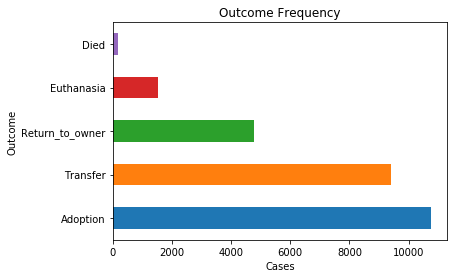

In [5]:
# outcome type
ax =df.OutcomeType.value_counts().plot(kind='barh', title='Outcome Frequency')
ax.set_xlabel("Cases")
ax.set_ylabel("Outcome")

Dog    15586
Cat    11102
Name: AnimalType, dtype: int64


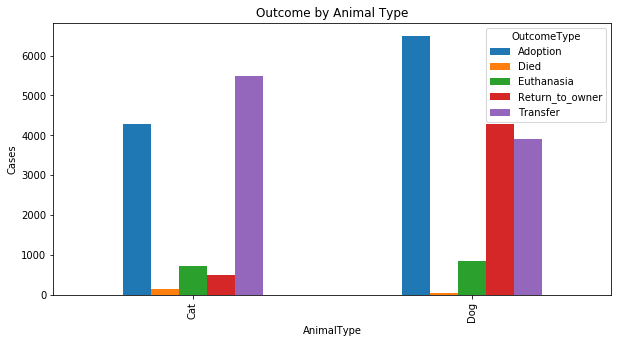

In [6]:
# Outcome by animal type

ax = pd.crosstab(df.AnimalType, df.OutcomeType, margins=False).plot(kind='bar', title='Outcome by Animal Type', figsize=(10,5))
ax.set_ylabel("Cases")
print df.AnimalType.value_counts()

(-0.5, 399.5, 199.5, -0.5)

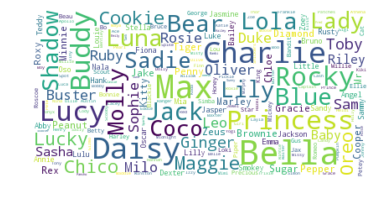

In [7]:
names =list(df.loc[df.HasName == True, ['Name']].apply(lambda x: '%s' % (x['Name']) ,axis=1))
names = " ".join(names)
wordcloud = WordCloud(max_font_size=40, background_color='white').generate(names)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")




(0, 6000)

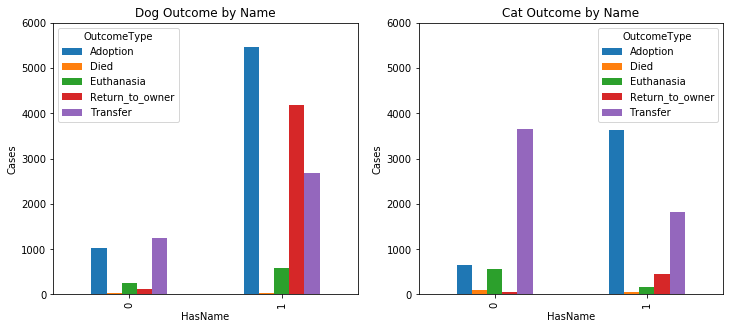

In [8]:
# Effect of name, animal type on outcome
fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = pd.crosstab(df.loc[df.AnimalType=='Dog','HasName'], df.OutcomeType, margins=False).plot(kind='bar', ax=axes[0], title='Dog Outcome by Name', figsize=(12,5))
ax2 = pd.crosstab(df.loc[df.AnimalType=='Cat','HasName'], df.OutcomeType, margins=False).plot(kind='bar', ax=axes[1], title='Cat Outcome by Name', figsize=(12,5))
ax1.set_ylabel("Cases")
ax2.set_ylabel("Cases")
ax1.set_ylim([0, 6000])
ax2.set_ylim([0, 6000])


#ax = df.OutcomeType.value_counts().plot(kind='bar',title="Outcome Frequency")
#ax.set_xlabel("Outcome")
#ax.set_ylabel("Cases")
#pd.crosstab(df.O, df.OutcomeType,margins=False)
#print df.HasName.value_counts()
#df.HasName.value_counts().plot(kind='bar')


In [10]:
# functions to calculate name frequency
def get_name_freq(names_freq, name):
    freq = 0.
    try:
        freq = names_freq[name]
    except:
        freq = 0.
    return freq
    
def create_name_freq(data, names_freq, drop):
    data.loc[:,"NameFreq"] = 0.
    data.loc[data.HasName==True, "NameFreq"] = data.loc[data.HasName==True, "Name"].apply(lambda x: get_name_freq(names_freq, x)) 
    if drop == True:
        return data.drop(['Name'], axis=1)    
    return data


# create dictionary of individual breed keys and count values
# If mix allocate 1/2 to each breed 
def create_feature_dictionary(feature_series):
    # we expect the breed column to be split into a list of subbreeds
    # it is assumed that breeds will be split in two sub-breeds at most
    feature_dict = {}
    for feature in feature_series:
        for subfeature in feature:
            try:                
                feature_dict[subfeature.strip()] += 1.0 / len(feature)
            except:
                feature_dict[subfeature.strip()] = 1.0 / len(feature)
    return feature_dict


#for key, value in sorted(dog_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True):
#    print "%s: %s" % (key, value)

# compute frequency of animal in data set.  
def get_feature_freq(feature_counts, feature_list):
    freq = 0.
    #feature_count = len(feature_list)
    for x in feature_list:
        try:                
            freq += feature_counts[x]
            #print "dog %s; freq %d; cnt %d" % (x, freq, breed_count)
        except:
            freq += 0
        #freq = freq / breed_count    
    return freq

# return original dataframe df augment with freqency in freq_col_name field
def calculate_feature_freq(df, feature_series, freq_col_name, feature_dict):
    feature_series_ = feature_series.apply(lambda x: sorted(i.strip() for i in x))       
    # calculate log frequency and store in specified column name within temp data frame    
    frequencies = np.log(feature_series_.apply(lambda x: get_feature_freq(feature_dict, x) + 1))
    #frequencies = breed_series_.apply(lambda x: get_breed_freq(breed_dict, x)) 
    # create data frame storing frequencies + original index
    # by retaining the original index of the breed rows, it will easy to merge join this frame with the original set        

    # join original data frame with frequency frame    
    temp_df = pd.merge(df, pd.DataFrame({freq_col_name: frequencies}, index=frequencies.index), 
                        how='left', left_index=True, right_index=True)
    
    # set empty frequency (belonging to other animal type) to 0.
    temp_df[freq_col_name] = np.where(temp_df[freq_col_name].isnull() == True, 0., temp_df[freq_col_name])
    return temp_df

(-0.5, 399.5, 199.5, -0.5)

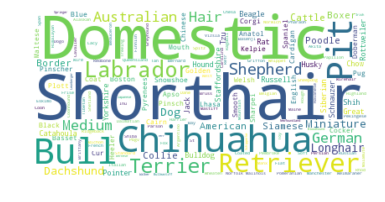

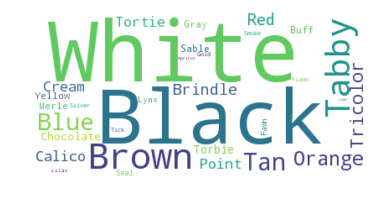

In [11]:
# Some breed color exploration
# add name, color and breed frequency columns to plot
name_train = df.loc[df.Name.isnull() == False, 'Name'].apply(lambda x: x.split('/',1))
colours_train = df.loc[:, 'Color'].apply(lambda x: x.split('/',1))
breeds_train = df.loc[:, 'Breed'].apply(lambda x: x.replace('Mix', '').split('/',1))
        
col_dict = create_feature_dictionary(colours_train)
breed_dict = create_feature_dictionary(breeds_train)
name_dict = create_feature_dictionary(name_train)


if (not('NameFreq' in df.columns)):
    df  =(df
        .pipe(calculate_feature_freq, breeds_train, 'BreedFreq', breed_dict)            
        .pipe(calculate_feature_freq, colours_train, 'ColorFreq', col_dict)    
        .pipe(calculate_feature_freq, name_train, 'NameFreq', name_dict)     
    )

#df2 = df.loc[df.AnimalType == 'Cat', ["Name", "Breed", "Color", "NameFreq", "BreedFreq", "ColorFreq", "OutcomeType"]]
#df.loc[:,['NameFreq', 'OutcomeType']].groupby("OutcomeType").NameFreq.plot(kind='kde', legend=True, figsize=(10,5), title="Density plot of (log) name popularity by outcome")
#df.loc[:,['BreedFreq', 'OutcomeType']].groupby("OutcomeType").BreedFreq.plot(kind='kde', legend=True, figsize=(10,5), title="Density plot of (log) name popularity by outcome")

# sort dictionaries in descending term count order
#for key, value in sorted(breed_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    #print "%s: %s" % (key, value)
    
#for key, value in sorted(col_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True):
 #   print "%s: %s" % (key, value)

# generate breed strings from dictionary
breeds =[x[0] for x in breed_dict.items() for y in range(int(x[1]))]
# unravel list into one text field
breeds = " ".join(breeds)
# show breeds
wordcloud = WordCloud(max_font_size=100, collocations=False, background_color='white',                       
                      max_words=5000).generate(breeds)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# repeat for color
colors =[x[0] for x in col_dict.items() for y in range(int(x[1]))]
# unravel list into one text field
colors = " ".join(colors)
# show breeds
wordcloud = WordCloud(max_font_size=100, collocations=False, background_color='white'
                      ).generate(colors)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


In [ ]:
#for key, value in sorted(name_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    #print "%s: %s" % (key, value)

#df.loc[df.HasName == True, ["NameFreq", "OutcomeType"]].groupby("OutcomeType").NameFreq.plot(kind='kde',figsize=(20,10))
#df.loc[:, ["AgeInYears", "OutcomeType"]].groupby("OutcomeType").AgeInYears.plot(kind='kde',figsize=(20,10))
#df.loc[:, ["TimeOfDay", "OutcomeType"]].groupby("OutcomeType").TimeOfDay.plot(kind='kde',figsize=(20,10))
#df.loc[:,['SinTime', 'CosTime']].plot.scatter('SinTime','CosTime').set_aspect('equal');


#df.loc[df.AnimalType == 'Dog', ["DogColorFreq", "OutcomeType"]].groupby("OutcomeType").DogColorFreq.plot(kind='kde',figsize=(20,10))
#plt.show()
#df.loc[df.Name.isnull() == False, 'NameFreq'].plot(kind='hist')

Text(0,0.5,u'Count')

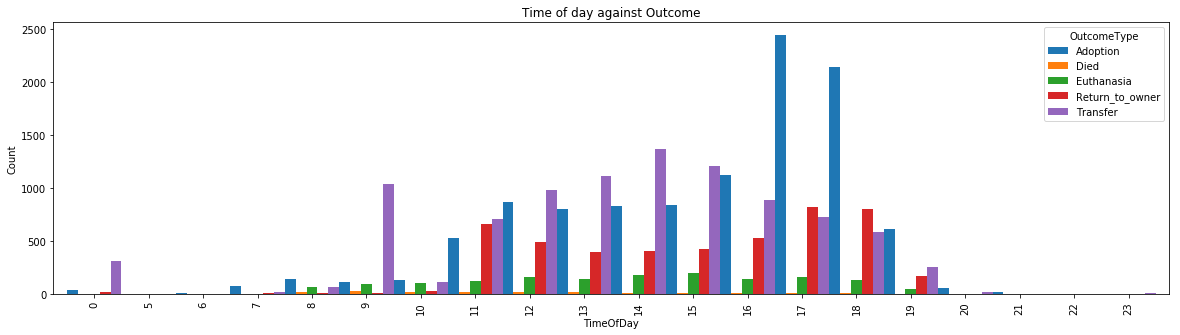

In [12]:
# Date visualisations 
#df.head()
#df.columns
# plot line graph of week day by outcome


#pd.crosstab(df.AgeCategory, df.OutcomeType,margins=False).plot(kind='line', figsize=(10,6))
ax = pd.crosstab(df.TimeOfDay, df.OutcomeType,margins=False).plot(kind='bar', figsize=(20,5), width=1.0, title='Time of day against Outcome')
ax.set_ylabel("Count")
#df.sample(1000).plot.scatter('SinWeek','CosWeek').set_aspect('equal');
#df.plot.scatter('SinDayOfWeek','CosDayOfWeek').set_aspect('equal');
#df.plot.scatter('SinMonth','CosMonth').set_aspect('equal');
#plt.show()


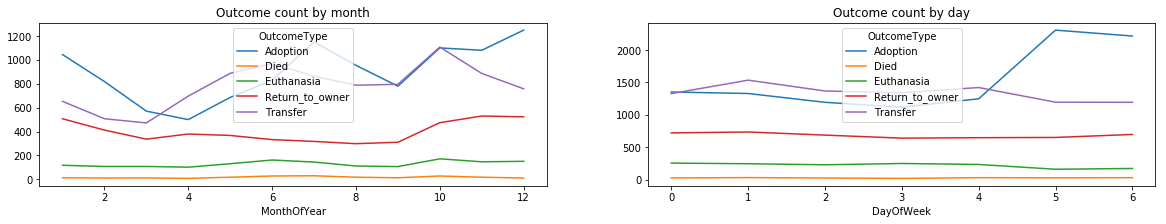

In [13]:
# plot month and day against outcome
fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = pd.crosstab(df.MonthOfYear, df.OutcomeType,margins=False).plot(kind='line', figsize=(20,3), ax=axes[0], title='Outcome count by month')
day_of_week = pd.crosstab(df.DayOfWeek, df.OutcomeType,margins=False)
ax2 = day_of_week.plot(kind='line', figsize=(20,3), ax=axes[1], title='Outcome count by day')
#ax1.set_ylabel("Count")
#ax2.set_ylabel("Count")

OutcomeType
Adoption           AxesSubplot(0.125,0.125;0.775x0.755)
Died               AxesSubplot(0.125,0.125;0.775x0.755)
Euthanasia         AxesSubplot(0.125,0.125;0.775x0.755)
Return_to_owner    AxesSubplot(0.125,0.125;0.775x0.755)
Transfer           AxesSubplot(0.125,0.125;0.775x0.755)
Name: AgeInDays, dtype: object

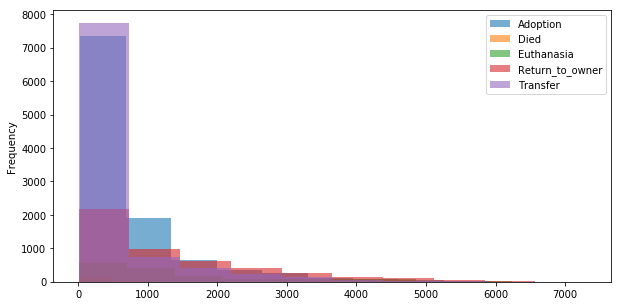

In [14]:
df.loc[:,['AgeInDays', 'OutcomeType']].groupby("OutcomeType").AgeInDays.plot(kind='hist', legend=True, figsize=(10,5), alpha=0.6)

In [15]:
# get features based on mode:
# mode = 0, no data fields are included
# mode = 1, one-hot encoded date fields are included - quite sparse
# mode = 2, replace categories with continuous variables
# mode = 3, get all data
def get_features(df, mode=0, drop_first=True ):         
    
    no_date_columns = (['AnimalType','Sex','BreedPurity','AgeCategory'], # categorical
                       ['HasName', 'Neutered', 'OutcomeType'] # don't remove
                       ) 

    categorised_date = (['AnimalType', 'Sex', 'BreedPurity', 'AgeCategory','Season','DayOfWeek','MonthOfYear','TimeOfDay'], # categorical
                        ['HasName','Neutered','IsWeekend','OutcomeType'] # don't remove
                        )         

    contin_data = (['AnimalType', 'Sex', 'BreedPurity', 'DayOfWeek'],
                   ['HasName', 'Neutered', 'Name', 'Breed', 'Color', 'AgeInDays', 'SinMonth', 'CosMonth','SinTime', 'CosTime', 'OutcomeType'] # don't remove
                  )
            
    #col3 = (['AnimalType','Gender', 'BreedPurity', 'AgeCategory', 'DayOfWeek', 'MonthOfYear', 'TimeOfDay'], # categorical
    #        ['HasName', 'IsOperated', 'Name', 'OutcomeType', 'Breed', 'Color'] # don't remove
    #        ) 

    #(['AnimalType','Gender', 'BreedPurity', 'DayOfWeek'], # categorical

    all_coll = (['AnimalType', 'Sex', 'BreedPurity', 'AgeCategory','Season','DayOfWeek','MonthOfYear','TimeOfDay'], # categorical
                ['HasName', 'Neutered', 'Name', 'Breed', 'Color', 'AgeInDays', 'SinTime', 'CosTime', 'OutcomeType'] # don't remove
                ) 
#'SinMonth', 'CosMonth','SinTime', 'CosTime'
    mode_dictionary = {0:no_date_columns, 1:categorised_date, 2:contin_data, 3:all_coll}
    
    #cols = [col1, col2, col4, all_coll]
    #model_frames = []
    #for x in cols:
     #   model_frames.append(get_features(df, x[0], x[1]))    
    to_remove = [x for x in df.columns.tolist() if x not in mode_dictionary[mode][0] + mode_dictionary[mode][1]]
    return pd.get_dummies(df, columns=mode_dictionary[mode][0], drop_first=drop_first).drop(to_remove, axis=1)
    
    

In [16]:
# 91.3% of cats are domestic animals of various hair length.  
# As an experiment to experiment with dimensionality reduction  

# extracts breed and colour features from dataframe
def get_text_features(df):
    text_features = list(df.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
    return text_features

def get_breed_features(df):
    text_features = list(df.apply(lambda x: '%s' % (x['Breed']),axis=1))
    return text_features

def get_color_features(df):
    text_features = list(df.apply(lambda x: '%s' % (x['Color']),axis=1))
    return text_features

# returns vectorizer and sparse term matrix
def vectorise_text(text_features):
    ctv = CountVectorizer(binary=True, min_df=10, max_df=0.6, ngram_range=(1,1))    
    #ctv = CountVectorizer(binary=True, ngram_range=(1,2))    
    count_vector = ctv.fit_transform(text_features)
    return ctv, count_vector

# returns fitted SVD transformer and transformed text features
def svd_count_matrix(term_count_matrix, components=10):    
    svd = TruncatedSVD(components)
    svd_array = svd.fit_transform(term_count_matrix)
    return svd, svd_array    

# plot terms by weight and component
def plot_weighted_terms_by_component(svd, feat_names, component_size):
    for compNum in range(0, component_size):
        comp = svd.components_[compNum]

        # Sort the weights in the first component, and get the indeces
        indices = np.argsort(comp).tolist()
        #print len(indices)
        # Reverse the indeces, so we have the largest weights first.
        indices.reverse()

        # Grab the top 10 terms which have the highest weight in this component.        
        terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
        weights = [comp[weightIndex] for weightIndex in indices[0:10]]    

        # Display these terms and their weights as a horizontal bar graph.    
        # The horizontal bar graph displays the first item on the bottom; reverse
        # the order of the terms so the biggest one is on top.
        terms.reverse()
        weights.reverse()
        positions = np.arange(10) + .5    # the bar centers on the y axis

        plt.figure(compNum)
        plt.barh(positions, weights, align='center')
        plt.yticks(positions, terms)
        plt.xlabel('Weight')
        plt.title('Strongest terms for component %d' % (compNum))
        plt.grid(True)
        

0.814612617089482
(26688, 163)


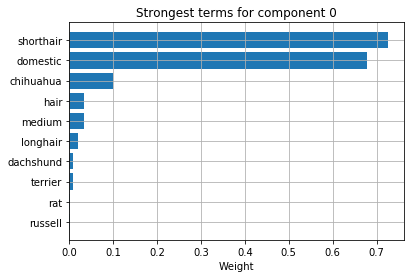

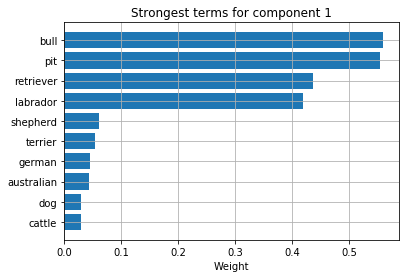

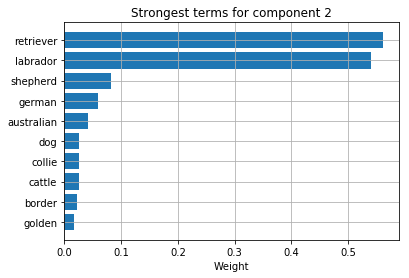

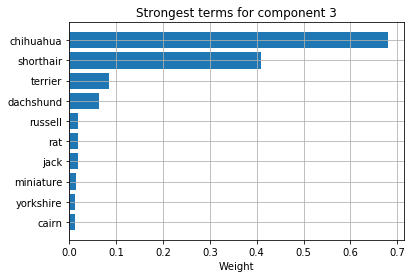

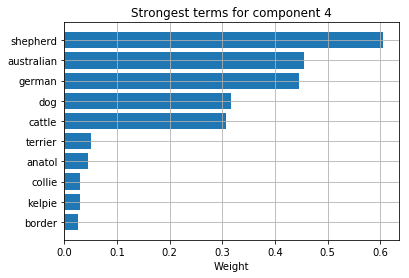

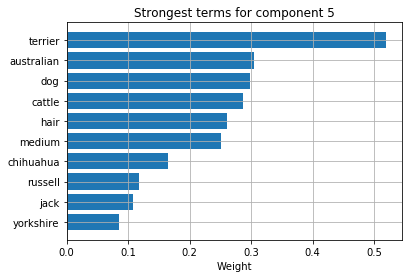

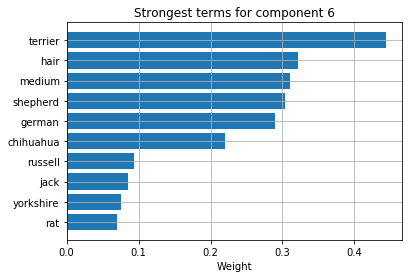

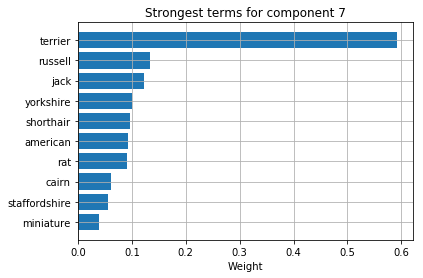

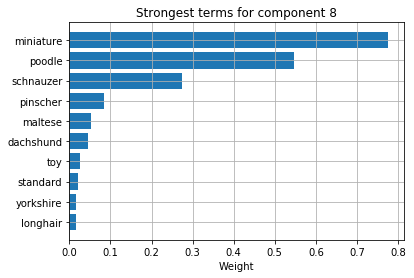

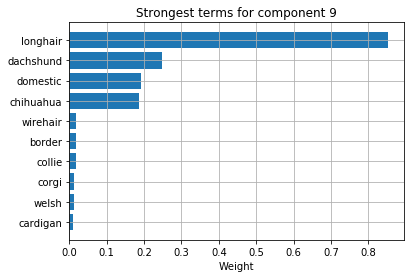

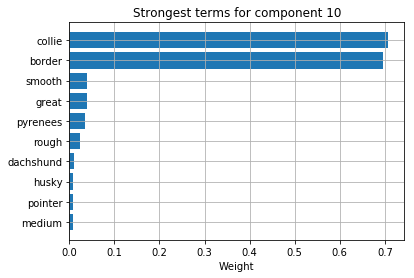

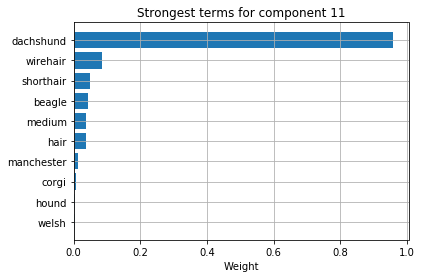

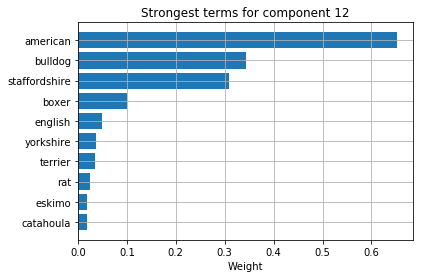

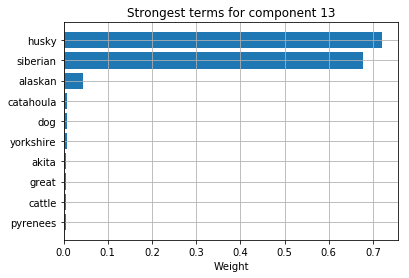

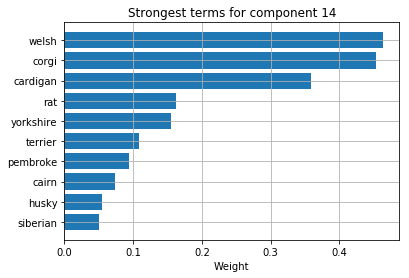

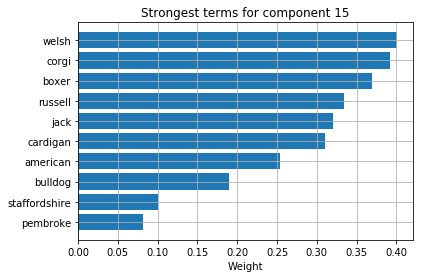

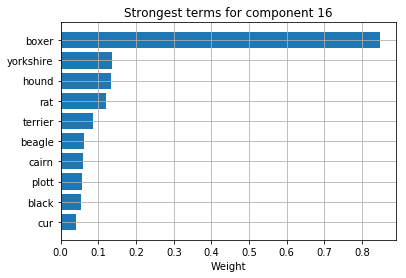

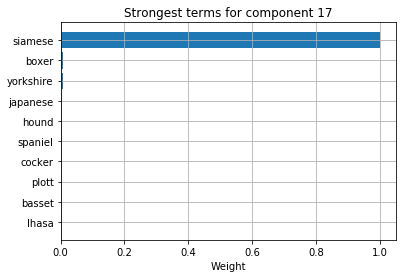

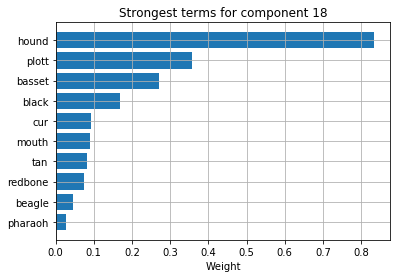

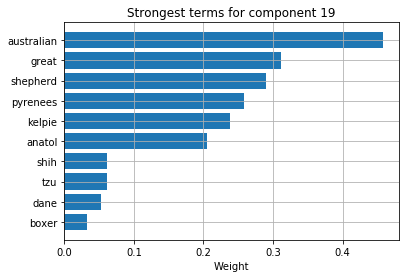

In [17]:
# plot 10 SVD components of breed/colour uni/bigrams
#text_features = get_text_features(model_frames[3].loc[model_frames[3]["AnimalType_Dog"]==1,:])
model_df = get_features(df, mode=2, drop_first=True )
text_features = get_breed_features(model_df)
#text_features = get_color_features(model_df.loc[model_df["AnimalType_Dog"] == 1,:])
ctv, count_vector = vectorise_text(text_features)
len(ctv.get_feature_names()) #320 features
svd, svd_array = svd_count_matrix(count_vector, components=20)
plot_weighted_terms_by_component(svd, ctv.get_feature_names(), 20)
print np.sum(svd.explained_variance_ratio_)
print count_vector.shape


In [29]:
def stack_svd_array(array, is_dog_idx, svd_array):        
    cat_svd = np.zeros((array[ array[:,is_dog_idx] == 0,:].shape[0], 10))   
    
    dog_arr = np.hstack((array[ array[:,is_dog_idx] == 1,:], svd_array))
    cat_arr = np.hstack((array[ array[:,is_dog_idx] == 0,:], cat_svd))
    return np.vstack((dog_arr, cat_arr))

def get_train_valid_sets(df_model, animal='both', include_svd=False, components=10, df_test=None):
    
    expl_variables = [x for x in df_model.columns if x not in ['OutcomeType']]    
    if (animal == 'both'):
        X = df_model.loc[:,expl_variables]
        y = df_model.loc[:,'OutcomeType']
    elif (animal == 'dog'):
        X = df_model.loc[df_model.AnimalType_Dog == 1, expl_variables]
        y = df_model.loc[df_model.AnimalType_Dog == 1, 'OutcomeType']        
            
    else:
        X = df_model.loc[df_model.AnimalType_Dog == 0, expl_variables]
        y = df_model.loc[df_model.AnimalType_Dog == 0, 'OutcomeType']
    
    le = LabelEncoder()
    y = le.fit_transform(y)

    # stratify test/validation split
    # split into train and test
    
    eval_size = 0.1
    kf = StratifiedKFold(y, round(1./eval_size))    
    train_indices, valid_indices = next(iter(kf))

    X_train, y_train = X.iloc[train_indices,:], y[train_indices]
    X_valid, y_valid = X.iloc[valid_indices,:], y[valid_indices]
    
    if df_test != None:
        X_valid = df_test
        y_value = None
            
    if include_svd:
        # extract text featuresd from train/valid set
        train_text_features = get_breed_features(X_train)
        valid_text_features = get_breed_features(X_valid)
        # fit vectoriser and return sparse matrix of terms transformed into vector space
        ctv, train_count_matrix = vectorise_text(train_text_features)
        # transform our validation features into vector space
        valid_count_matrix = ctv.transform(valid_text_features)
                
        # compute svd reduction of original term array
        svd, train_svd_array = svd_count_matrix(train_count_matrix, components=components)
        valid_svd_array = svd.transform(valid_count_matrix)     
                
    
    # let's include name frequency but avoid leaking names found in the validation set
    if ('Name' in expl_variables):        
        names_train = X_train.loc[X_train.Name.isnull() == False, 'Name'].apply(lambda x: x.split("/",1))
        names_valid = X_valid.loc[X_valid.Name.isnull() == False, 'Name'].apply(lambda x: x.split("/",1))
        name_dict = create_feature_dictionary(names_train)        
        X_train = X_train.pipe(calculate_feature_freq, names_train, 'NamesFreq', name_dict).drop(['Name'], axis=1)
        X_valid = X_valid.pipe(calculate_feature_freq, names_valid, 'NamesFreq', name_dict).drop(['Name'], axis=1)

    # include breed frequency based on observations in training set
    if ('Breed' in expl_variables ):
        
        breeds_train = X_train.loc[X_train.AnimalType_Dog == 1, 'Breed'].apply(lambda x: x.replace('Mix', '').split('/',1))
        cat_breeds_train  = X_train.loc[X_train.AnimalType_Dog == 0, 'Breed'].apply(lambda x: x.replace('Mix', '').split('/',1))                        
        # frequency dictionary based on training set alone
        breed_dict = create_feature_dictionary(breeds_train)
        cat_dict = create_feature_dictionary(cat_breeds_train)
        
        X_train =(X_train
            .pipe(calculate_feature_freq, breeds_train, 'DogBreedFreq', breed_dict)            
            .pipe(calculate_feature_freq, cat_breeds_train, 'CatBreedFreq', cat_dict)            
            .drop(['Breed'], axis=1)
        )
        
        breeds_valid = X_valid.loc[X_valid.AnimalType_Dog == 1, 'Breed'].apply(lambda x: x.replace('Mix', '').split('/',1))
        cat_breeds_valid  = X_valid.loc[X_valid.AnimalType_Dog == 0, 'Breed'].apply(lambda x: x.replace('Mix', '').split('/',1))
        
        X_valid =(X_valid
            .pipe(calculate_feature_freq, breeds_valid, 'DogBreedFreq', breed_dict)            
            .pipe(calculate_feature_freq, cat_breeds_valid, 'CatBreedFreq', cat_dict)            
            .drop(['Breed'], axis=1)
        )
                
    
    # include color frequency based on observations in training set
    if ('Color' in expl_variables ):        
        # calculate colour frequency which will introduce a popularity feature to the set
        # breed series
        colours_train = X_train.loc[X_train.AnimalType_Dog == 1, 'Color'].apply(lambda x: x.split('/',1))
        cat_colours_train = X_train.loc[X_train.AnimalType_Dog == 0, 'Color'].apply(lambda x: x.split('/',1))
        
        col_dict = create_feature_dictionary(colours_train)
        cat_col_dict = create_feature_dictionary(cat_colours_train)
        
        X_train =(X_train
            .pipe(calculate_feature_freq, colours_train, 'DogColorFreq', col_dict)            
            .pipe(calculate_feature_freq, cat_colours_train, 'CatColorFreq', cat_col_dict)            
            .drop(['Color'], axis=1)
        )

        colours_valid = X_valid.loc[X_valid.AnimalType_Dog == 1, 'Color'].apply(lambda x: x.split('/',1))
        cat_colours_valid = X_valid.loc[X_valid.AnimalType_Dog == 0, 'Color'].apply(lambda x: x.split('/',1))
        
        X_valid =(X_valid
            .pipe(calculate_feature_freq, colours_valid, 'DogColorFreq', col_dict)        
            .pipe(calculate_feature_freq, cat_colours_valid, 'CatColorFreq', cat_col_dict)        
            .drop(['Color'], axis=1)
        )
                
    
    expl_variables = X_train.columns    
    
    X_train = X_train.values
    X_valid = X_valid.values
    
    if include_svd:                                
        X_train = np.hstack((X_train, train_svd_array))
        X_valid = np.hstack((X_valid, valid_svd_array))
        # add svd component columns to our array of column names
        expl_variables = np.hstack((expl_variables, np.asarray(["SVD_" + str(x) for x in range(components)]))) 
                    
    return X_train, X_valid, y_train, y_valid, expl_variables, le.classes_



In [19]:
# Check label proportions
def get_class_proportions(y):    
    _foo = Counter(y)
    return [round(float(_foo[x]) / sum(_foo.values()),3)  for x in _foo]

# routine to plot RF features by importance 
# Python Machine Learning, Raschka
def plot_feature_importance(importances, indices, feature_count, extended_model_columns):    
    fig = plt.figure(figsize=(20, 10))
    plt.title('Feature Importance')    
    plt.bar(range(feature_count),importances[indices[0:feature_count]], color='lightblue', align='center')
    plt.xticks(range(feature_count), extended_model_columns[indices[0:feature_count]], rotation = 90)
    plt.xlim([-1, feature_count])
    plt.tight_layout()
    
    #plt.show()
    #plt.close()
    
# plot confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
# estimate mutual information for target variables
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Get all variables and perform "filter" feature selection
model_df = get_features(df, mode=3)
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, animal='both', include_svd=False, components=20)

discrete_features=[1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0]
mut_inf = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)


In [33]:
# continued from above...
# print columns in order of mutual information
indices = np.argsort(mut_inf)[::-1]
expl_variables[np.argsort(mut_inf *-1)]

top_feature_dict = {expl_variables[x]:mut_inf[x] for x in indices}
# sort features by score
for key, value in sorted(top_feature_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    print "%s: %s" % (key, value)

Neutered: 0.19797866037670947
AgeInDays: 0.18071368934708665
SinTime: 0.12241630718849228
NamesFreq: 0.11634630606752028
HasName: 0.11037371867337031
CosTime: 0.09967173458326473
DogBreedFreq: 0.096262153872817
DogColorFreq: 0.07109290695871184
CatColorFreq: 0.06910539187109777
CatBreedFreq: 0.06663540103275034
AnimalType_Dog: 0.06115159532186265
AgeCategory_2: 0.048768690401197023
Sex_U: 0.03175021013897261
AgeCategory_6: 0.030960294754305284
TimeOfDay_9: 0.02482578242562239
TimeOfDay_17: 0.018605406765504373
TimeOfDay_18: 0.014959153814287252
AgeCategory_3: 0.012924111317718534
DayOfWeek_2: 0.012713273068896136
TimeOfDay_7: 0.011770179848906714
AgeCategory_5: 0.01146057875923523
TimeOfDay_11: 0.011033852559401591
AgeCategory_7: 0.010245490497692522
TimeOfDay_15: 0.009391638653132528
Season_winter: 0.007942500138608644
Season_spring: 0.007877530967499435
DayOfWeek_6: 0.007650694773194466
TimeOfDay_14: 0.0057618459309152215
DayOfWeek_1: 0.005254415109553268
BreedPurity_pure: 0.00452962

[1.10373719e-01 1.97978660e-01 1.80713689e-01 1.22416307e-01
 9.96717346e-02 6.11515953e-02 2.34190373e-04 3.17502101e-02
 4.52962083e-03 4.87686904e-02 1.29241113e-02 9.90883105e-05
 1.14605788e-02 3.09602948e-02 1.02454905e-02 7.87753097e-03
 0.00000000e+00 7.94250014e-03 5.25441511e-03 1.27132731e-02
 0.00000000e+00 0.00000000e+00 3.31926496e-03 7.65069477e-03
 1.18517606e-03 3.18033630e-03 0.00000000e+00 8.68986882e-04
 0.00000000e+00 0.00000000e+00]
[ 1  2  3 54  0  4 55 57 58 56  5  9  7 13 39 47 48 10 19 37 12 41 14 45
 17 15 23 44 18  8]


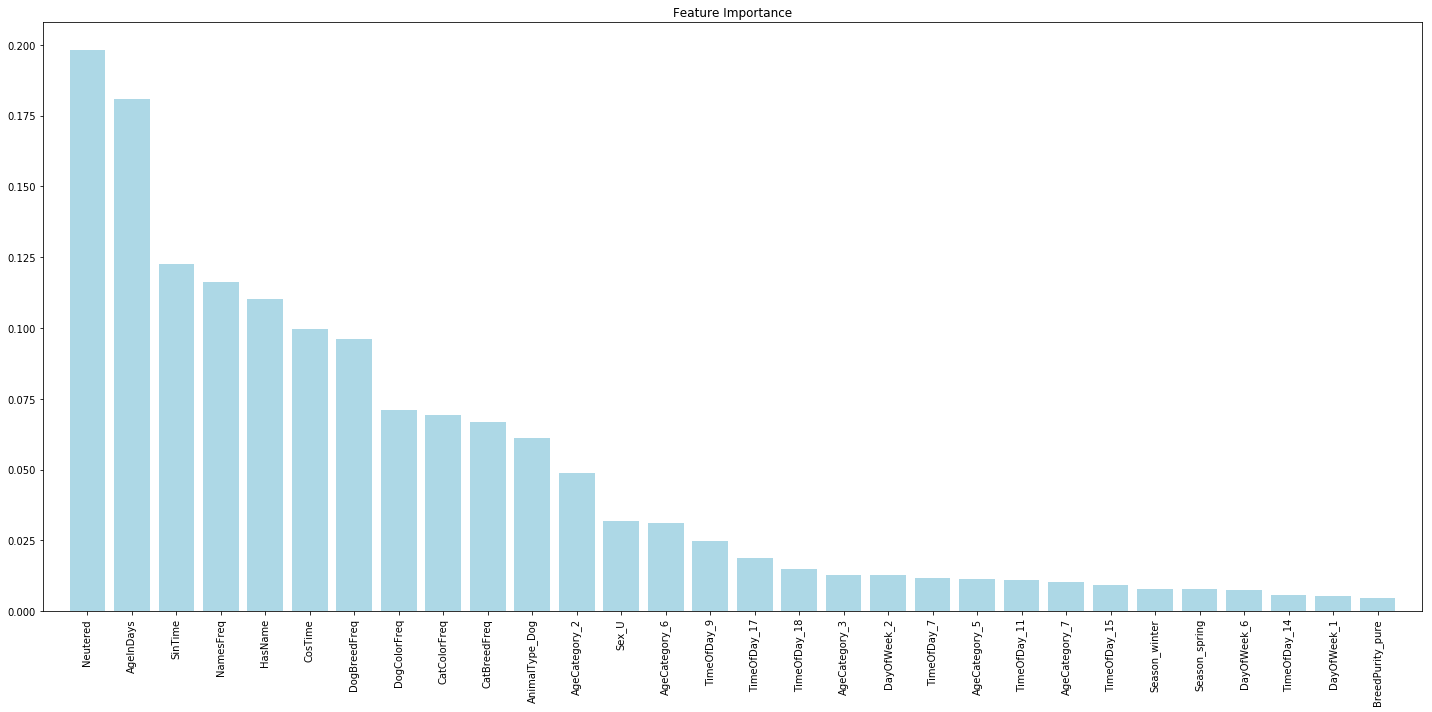

In [34]:
print mut_inf[:30]
print indices[:30]
plot_feature_importance(mut_inf, indices[:30], 30, expl_variables)   


In [35]:
# continued from above
# run same with SVD components
# Get all variables and perform "filter" feature selection
model_df = get_features(df, mode=3)
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, animal='both', include_svd=True, components=20)
print expl_variables
discrete_features=[1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
mut_inf_svd = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)



['HasName' 'Neutered' 'AgeInDays' 'SinTime' 'CosTime' 'AnimalType_Dog'
 'Sex_M' 'Sex_U' 'BreedPurity_pure' 'AgeCategory_2' 'AgeCategory_3'
 'AgeCategory_4' 'AgeCategory_5' 'AgeCategory_6' 'AgeCategory_7'
 'Season_spring' 'Season_summer' 'Season_winter' 'DayOfWeek_1'
 'DayOfWeek_2' 'DayOfWeek_3' 'DayOfWeek_4' 'DayOfWeek_5' 'DayOfWeek_6'
 'MonthOfYear_2' 'MonthOfYear_3' 'MonthOfYear_4' 'MonthOfYear_5'
 'MonthOfYear_6' 'MonthOfYear_7' 'MonthOfYear_8' 'MonthOfYear_9'
 'MonthOfYear_10' 'MonthOfYear_11' 'MonthOfYear_12' 'TimeOfDay_5'
 'TimeOfDay_6' 'TimeOfDay_7' 'TimeOfDay_8' 'TimeOfDay_9' 'TimeOfDay_10'
 'TimeOfDay_11' 'TimeOfDay_12' 'TimeOfDay_13' 'TimeOfDay_14'
 'TimeOfDay_15' 'TimeOfDay_16' 'TimeOfDay_17' 'TimeOfDay_18'
 'TimeOfDay_19' 'TimeOfDay_20' 'TimeOfDay_21' 'TimeOfDay_22'
 'TimeOfDay_23' 'NamesFreq' 'DogBreedFreq' 'CatBreedFreq' 'DogColorFreq'
 'CatColorFreq' 'SVD_0' 'SVD_1' 'SVD_2' 'SVD_3' 'SVD_4' 'SVD_5' 'SVD_6'
 'SVD_7' 'SVD_8' 'SVD_9' 'SVD_10' 'SVD_11' 'SVD_12' 'SVD_13' 'SVD_

[['BreedPurity_pure']
 ['Season_spring']
 ['DayOfWeek_4']
 ['MonthOfYear_3']
 ['MonthOfYear_5']
 ['MonthOfYear_6']
 ['MonthOfYear_9']
 ['MonthOfYear_11']
 ['TimeOfDay_5']
 ['TimeOfDay_6']
 ['TimeOfDay_7']
 ['TimeOfDay_13']
 ['TimeOfDay_22']
 ['TimeOfDay_23']]
Valuable feature vector count = 65
14 features removed
[]
['Neutered' 'AgeInDays' 'TimeOfDay_10' 'SinTime' 'HasName' 'CosTime'
 'SVD_2' 'TimeOfDay_15' 'NamesFreq' 'SVD_0' 'CatBreedFreq' 'TimeOfDay_16'
 'TimeOfDay_17' 'SVD_5' 'TimeOfDay_20' 'CatColorFreq' 'DogColorFreq'
 'SVD_3' 'TimeOfDay_19' 'TimeOfDay_23' 'SVD_1' 'DogBreedFreq' 'SVD_4'
 'TimeOfDay_22' 'TimeOfDay_21' 'TimeOfDay_11' 'TimeOfDay_18'
 'TimeOfDay_13' 'AnimalType_Dog' 'TimeOfDay_12' 'TimeOfDay_14'
 'BreedPurity_pure' 'Sex_U' 'AgeCategory_5' 'MonthOfYear_6'
 'AgeCategory_4' 'TimeOfDay_6' 'TimeOfDay_5' 'AgeCategory_2'
 'MonthOfYear_4' 'Season_spring' 'AgeCategory_6' 'MonthOfYear_5' 'Sex_M'
 'DayOfWeek_3' 'MonthOfYear_8' 'TimeOfDay_8' 'AgeCategory_3' 'DayOfWeek_6'
 'DayOf

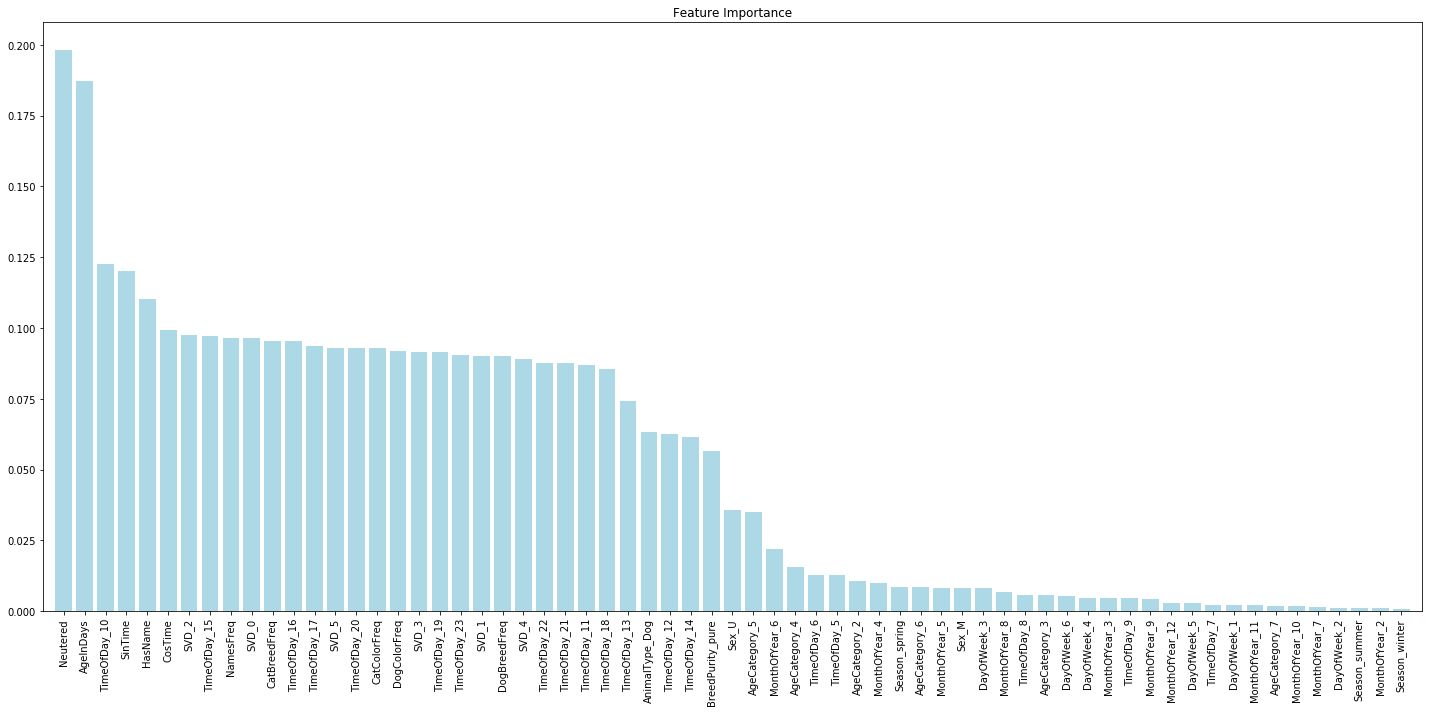

In [36]:
# continued from above...
# let's print and remove the features that scored 0
print expl_variables[np.argwhere(mut_inf_svd == 0)]
indices_svd_all = np.argsort(mut_inf_svd)[::-1]
indices_svd = np.argsort(mut_inf_svd[mut_inf_svd > 0])[::-1]
print "Valuable feature vector count = %d" % (len(indices_svd))

print "%d features removed" % (len(expl_variables) - len(mut_inf_svd[mut_inf_svd > 0]))
expl_variables[np.argsort(mut_inf_svd[mut_inf_svd > 0] *-1)]

top_feature_dict_svd = {expl_variables[x]:mut_inf_svd[x] for x in indices_svd}
# sort features by score
#for key, value in sorted(top_feature_dict_svd.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    #print "%s: %s" % (key, value)
    
#print mut_inf_svd
#print indices_svd[:30]
plot_feature_importance(mut_inf_svd[mut_inf_svd>0], indices_svd, len(indices_svd), expl_variables)     

# by eyeballing this chart we could remove another 5 features: 
print expl_variables[indices_svd[65:]]
print expl_variables[indices_svd[:65]]

In [ ]:
len(mut_inf_svd[mut_inf_svd > 0])

In [37]:
import time
# Initial check to see which algorithm performs better on which set of engineered features

# initialise MinMax scaler
minmax = MinMaxScaler()

# initialise Standard scaler
stdscl = StandardScaler()
scoring = ['neg_log_loss', 'f1_weighted']
# initialise synthetic over-sampling
#smt = SMOTE(random_state=22, ratio='minority')

# basic logistic regression
lr = LogisticRegression(random_state=22, multi_class='multinomial', solver='lbfgs')
lr_multi_l1 = LogisticRegression(random_state=22, penalty='l1', multi_class='multinomial', solver='saga', C=1)
rf_basic = RandomForestClassifier(random_state=22, n_estimators=500)

#pipelines_w_smote = {'p_lr_multi': Pipeline([('smt', smt), ('minmax', minmax), ('lr', lr)]),
#                     'p_lr_multi_l1': Pipeline([('smt', smt), ('std', stdscl), ('lr_multi_l1', lr_multi_l1)]),             
#                     'p_basic_rf': Pipeline([('smt', smt), ('minmax', minmax), ('rf', rf_basic)])
#            }

pipelines = {'p_lr_multi': Pipeline([('minmax', minmax), ('lr', lr)]),
              'p_lr_multi_l1': Pipeline([('std', stdscl), ('lr_multi_l1', lr_multi_l1)]),             
              'p_basic_rf': Pipeline([('minmax', minmax), ('rf', rf_basic)])
            }

model_frames = [get_features(df, mode=x) for x in [3]]
validate = True
for f in model_frames:
    for animal in ['both']:        
        # set include_svd to false to exclude SVD breed components
        X_train, X_valid, y_train, y_valid, expl_variables, _ = get_train_valid_sets(f, animal, include_svd=True, components=20)
        
        print "Doing %s" % (animal)
        print expl_variables    
        if validate == True:
            for pipeline in pipelines:
                for score in scoring:
                    print "Doing %s scored by %s..." % (pipeline, score)
                    kfold = StratifiedKFold(y_train, n_folds=3, random_state=7)
                    t0 = time.time()
                    results = cross_val_score(pipelines[pipeline], X_train, y_train, cv=kfold, scoring=score)
                    t1 = time.time()                
                    print "Mean %s %.3f; std %.3f; time %.3f" % (score, results.mean(), results.std(), t1-t0)
                    print "~------------~"
            print "-------------------------------------------------"
        else:
            for pipeline in pipelines:
                print "Doing %s..." % (pipeline)
                pipelines[pipeline].fit(X_train, y_train)                
                y_pred = pipelines[pipeline].predict(X_valid)
                y_pred_prob = pipelines[pipeline].predict_proba(X_valid)
                f1 = f1_score(y_valid, y_pred, average='weighted') 
                ll = log_loss(y_valid, y_pred_prob)
                print "Log Loss %.3f, F1 score %.3f; " % (ll, f1)
            print "-------------------------------------------------"


Doing both
['HasName' 'Neutered' 'AgeInDays' 'SinTime' 'CosTime' 'AnimalType_Dog'
 'Sex_M' 'Sex_U' 'BreedPurity_pure' 'AgeCategory_2' 'AgeCategory_3'
 'AgeCategory_4' 'AgeCategory_5' 'AgeCategory_6' 'AgeCategory_7'
 'Season_spring' 'Season_summer' 'Season_winter' 'DayOfWeek_1'
 'DayOfWeek_2' 'DayOfWeek_3' 'DayOfWeek_4' 'DayOfWeek_5' 'DayOfWeek_6'
 'MonthOfYear_2' 'MonthOfYear_3' 'MonthOfYear_4' 'MonthOfYear_5'
 'MonthOfYear_6' 'MonthOfYear_7' 'MonthOfYear_8' 'MonthOfYear_9'
 'MonthOfYear_10' 'MonthOfYear_11' 'MonthOfYear_12' 'TimeOfDay_5'
 'TimeOfDay_6' 'TimeOfDay_7' 'TimeOfDay_8' 'TimeOfDay_9' 'TimeOfDay_10'
 'TimeOfDay_11' 'TimeOfDay_12' 'TimeOfDay_13' 'TimeOfDay_14'
 'TimeOfDay_15' 'TimeOfDay_16' 'TimeOfDay_17' 'TimeOfDay_18'
 'TimeOfDay_19' 'TimeOfDay_20' 'TimeOfDay_21' 'TimeOfDay_22'
 'TimeOfDay_23' 'NamesFreq' 'DogBreedFreq' 'CatBreedFreq' 'DogColorFreq'
 'CatColorFreq' 'SVD_0' 'SVD_1' 'SVD_2' 'SVD_3' 'SVD_4' 'SVD_5' 'SVD_6'
 'SVD_7' 'SVD_8' 'SVD_9' 'SVD_10' 'SVD_11' 'SVD_12' 'SV

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean f1_weighted 0.657; std 0.002; time 4.277
~------------~
Doing p_lr_multi_l1 scored by neg_log_loss...


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Mean neg_log_loss -0.807; std 0.012; time 27.492
~------------~
Doing p_lr_multi_l1 scored by f1_weighted...
Mean f1_weighted 0.657; std 0.003; time 26.727
~------------~
-------------------------------------------------


In [39]:
# Based on best performing logistic regression:
# LR with L2 penalty; multinomial; lbfgs solver

# try to discover whether lr improves with less parameters
minmax = MinMaxScaler()

model_df = get_features(df, mode=3)
# get full features with SVD
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, animal='both', include_svd=True, components=20)
# show variables
print expl_variables[indices_svd]

# logistic regression will be the estimator
clf = LogisticRegression(random_state=1, multi_class='multinomial',solver='lbfgs',penalty='l2')
# Do grid search over k, n_components and C:
pipeline = Pipeline([("minmax", minmax ), ("clf", clf)])

param_range = [0.1, 1, 10]
param_grid = [{'clf__C':param_range,
               'clf__solver':['lbfgs'],
               'clf__multi_class':['multinomial']
              }]

# we could have used the SelectKBest but to my knowledge there's no way to pass the vector
# discrete variables flag which has an impact on calculating mutual information
grid_search_lr_top = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=True)
grid_search_lr_top.fit(X_train[:,indices_svd], y_train)
print(grid_search_lr_top.best_estimator_)
print(grid_search_lr_top.best_score_)

# removing those 9 features made no difference to the cross validated score
# they were indeed redundant

# but removing an addition 5 low quality feature had an impact on score 0.813


['Neutered' 'AgeInDays' 'TimeOfDay_10' 'SinTime' 'HasName' 'CosTime'
 'SVD_2' 'TimeOfDay_15' 'NamesFreq' 'SVD_0' 'CatBreedFreq' 'TimeOfDay_16'
 'TimeOfDay_17' 'SVD_5' 'TimeOfDay_20' 'CatColorFreq' 'DogColorFreq'
 'SVD_3' 'TimeOfDay_19' 'TimeOfDay_23' 'SVD_1' 'DogBreedFreq' 'SVD_4'
 'TimeOfDay_22' 'TimeOfDay_21' 'TimeOfDay_11' 'TimeOfDay_18'
 'TimeOfDay_13' 'AnimalType_Dog' 'TimeOfDay_12' 'TimeOfDay_14'
 'BreedPurity_pure' 'Sex_U' 'AgeCategory_5' 'MonthOfYear_6'
 'AgeCategory_4' 'TimeOfDay_6' 'TimeOfDay_5' 'AgeCategory_2'
 'MonthOfYear_4' 'Season_spring' 'AgeCategory_6' 'MonthOfYear_5' 'Sex_M'
 'DayOfWeek_3' 'MonthOfYear_8' 'TimeOfDay_8' 'AgeCategory_3' 'DayOfWeek_6'
 'DayOfWeek_4' 'MonthOfYear_3' 'TimeOfDay_9' 'MonthOfYear_9'
 'MonthOfYear_12' 'DayOfWeek_5' 'TimeOfDay_7' 'DayOfWeek_1'
 'MonthOfYear_11' 'AgeCategory_7' 'MonthOfYear_10' 'MonthOfYear_7'
 'DayOfWeek_2' 'Season_summer' 'MonthOfYear_2' 'Season_winter']
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.0s finished


Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])
-0.807076936869


In [41]:
# Lest try and get a sparse interpretation of the model, removing the 9 redundant features
# and training on an L1 regularised logistic regression model

# try to discover whether lr improves with less parameters
minmax = MinMaxScaler()

model_df = get_features(df, mode=3)
# get full features with SVD
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, animal='both', include_svd=True, components=20)
# show variables
print expl_variables[indices_svd]

# logistic regression will be the estimator
clf = LogisticRegression(random_state=1, multi_class='multinomial',solver='saga',penalty='l1', C=1)
# Do grid search over k, n_components and C:
pipeline = Pipeline([("minmax", minmax ), ("clf", clf)])

param_range = [1]
param_grid = [{'clf__C':param_range}]

# we could have used the SelectKBest but to my knowledge there's no way to pass the vector
# discrete variables flag which has an impact on calculating mutual information
grid_search_lr1_top = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=True)
grid_search_lr1_top.fit(X_train[:,indices_svd], y_train)
print(grid_search_lr1_top.best_score_)

# removing those 9 features made no difference to the cross validated score
# they were indeed redundant



['Neutered' 'AgeInDays' 'TimeOfDay_10' 'SinTime' 'HasName' 'CosTime'
 'SVD_2' 'TimeOfDay_15' 'NamesFreq' 'SVD_0' 'CatBreedFreq' 'TimeOfDay_16'
 'TimeOfDay_17' 'SVD_5' 'TimeOfDay_20' 'CatColorFreq' 'DogColorFreq'
 'SVD_3' 'TimeOfDay_19' 'TimeOfDay_23' 'SVD_1' 'DogBreedFreq' 'SVD_4'
 'TimeOfDay_22' 'TimeOfDay_21' 'TimeOfDay_11' 'TimeOfDay_18'
 'TimeOfDay_13' 'AnimalType_Dog' 'TimeOfDay_12' 'TimeOfDay_14'
 'BreedPurity_pure' 'Sex_U' 'AgeCategory_5' 'MonthOfYear_6'
 'AgeCategory_4' 'TimeOfDay_6' 'TimeOfDay_5' 'AgeCategory_2'
 'MonthOfYear_4' 'Season_spring' 'AgeCategory_6' 'MonthOfYear_5' 'Sex_M'
 'DayOfWeek_3' 'MonthOfYear_8' 'TimeOfDay_8' 'AgeCategory_3' 'DayOfWeek_6'
 'DayOfWeek_4' 'MonthOfYear_3' 'TimeOfDay_9' 'MonthOfYear_9'
 'MonthOfYear_12' 'DayOfWeek_5' 'TimeOfDay_7' 'DayOfWeek_1'
 'MonthOfYear_11' 'AgeCategory_7' 'MonthOfYear_10' 'MonthOfYear_7'
 'DayOfWeek_2' 'Season_summer' 'MonthOfYear_2' 'Season_winter']
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.2s finished


-0.806316445711


In [42]:
print indices_svd

important_coef = np.round(grid_search_lr1_top.best_estimator_.named_steps['clf'].coef_[:, indices_svd[:20]], 2)

pd.DataFrame(important_coef, index=range(0,5), columns = expl_variables[indices_svd[:20]])

# very strange, the neutered weigh seems to suggest that being neutered has a negative influence
# on being adopted.  The visualisation clearly show this to be false.  
# opting for a more complex model has sacrficed interpretability for performance

[ 1  2 40  3  0  4 61 45 54 59 56 46 47 64 50 58 57 62 49 53 60 55 63 52
 51 41 48 43  5 42 44  8  7 12 28 11 36 35  9 26 15 13 27  6 20 30 38 10
 23 21 25 39 31 34 22 37 18 33 14 32 29 19 16 24 17]


,Neutered,AgeInDays,TimeOfDay_10,SinTime,HasName,CosTime,SVD_2,TimeOfDay_15,NamesFreq,SVD_0,CatBreedFreq,TimeOfDay_16,TimeOfDay_17,SVD_5,TimeOfDay_20,CatColorFreq,DogColorFreq,SVD_3,TimeOfDay_19,TimeOfDay_23
0,-1.26,0.00,-0.04,-1.39,3.57,0.86,-0.03,0.38,0.85,-0.08,0.00,0.88,1.87,0.28,-0.10,0.00,-0.03,-0.11,0.03,0.11
1,0.00,0.00,0.00,2.89,-0.76,0.00,-0.22,0.00,0.00,0.11,0.00,0.00,-1.46,-0.14,0.01,-1.44,0.00,-0.16,0.00,-0.20
2,1.97,0.31,0.06,-0.21,-0.77,-1.14,0.00,0.00,-0.37,0.11,-0.05,0.80,0.69,0.00,0.08,0.85,0.16,0.20,-0.14,0.16
3,0.00,-1.24,0.14,0.00,0.68,2.10,0.12,-0.01,0.20,-0.15,0.13,-1.72,0.00,0.09,-0.07,0.00,0.07,0.00,-0.04,-0.01
4,-0.97,-1.67,-0.10,3.63,0.00,-0.01,0.06,-0.12,-0.12,0.00,0.11,-2.72,-0.66,-0.06,0.00,-2.25,0.00,0.04,0.06,0.00


In [43]:
# let's see the coefficients returned for a simple model

# try to discover whether lr improves with less parameters
minmax = MinMaxScaler()

model_df = get_features(df, mode=1)
# get full features with SVD
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, animal='both', include_svd=False, components=20)
# show variables

# logistic regression will be the estimator
clf = LogisticRegression(random_state=1, multi_class='multinomial',solver='saga',penalty='l1', C=1)
# Do grid search over k, n_components and C:
pipeline = Pipeline([("minmax", minmax ), ("clf", clf)])

param_range = [1]
param_grid = [{'clf__C':param_range}]

foo = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=True)
foo.fit(X_train, y_train)
print(foo.best_score_)

coef=np.round(foo.best_estimator_.named_steps['clf'].coef_,2)
pd.DataFrame(coef, index=range(0,5), columns = expl_variables)
# here neutered is positively correlated with adoption once again.  
# this seems to confirm my assertion earler

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished


-0.816613842844


,HasName,Neutered,IsWeekend,AnimalType_Dog,Sex_M,Sex_U,BreedPurity_pure,AgeCategory_2,AgeCategory_3,AgeCategory_4,...,TimeOfDay_14,TimeOfDay_15,TimeOfDay_16,TimeOfDay_17,TimeOfDay_18,TimeOfDay_19,TimeOfDay_20,TimeOfDay_21,TimeOfDay_22,TimeOfDay_23
0,0.99,3.56,0.54,0.19,-0.30,-2.85,-0.25,3.03,1.90,1.13,...,0.08,0.10,0.51,0.97,1.26,1.59,1.29,1.33,0.10,0.16
1,-0.07,-0.78,0.00,-0.51,0.04,0.04,0.00,0.00,-1.47,-1.77,...,-1.37,-1.47,-1.20,-1.23,-1.12,-1.43,0.10,0.00,0.00,0.00
2,-0.64,-0.83,-0.31,0.00,0.12,0.20,-0.36,0.77,0.69,0.86,...,0.00,0.10,0.00,0.00,0.00,0.00,-0.75,0.00,0.00,0.00
3,2.33,0.67,0.00,1.26,0.00,-0.05,0.00,-0.75,0.00,0.00,...,0.00,0.00,0.39,0.77,1.11,1.10,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.16,-0.09,-0.15,0.00,0.08,-0.80,-0.68,-1.15,...,-1.64,-1.86,-1.97,-2.40,-2.48,-2.05,-2.37,-1.39,-1.81,-0.42


In [44]:
# to see whether RF ranks the features in the same manner mutual information did
# we're removing those features considered redundant from the earler exercise
pipe_rf = Pipeline([('min_max', MinMaxScaler()),
                    ('clf', RandomForestClassifier(random_state=22, n_estimators=1000))])

# get all features
model_df = get_features(df, mode=3)
# get set most suited for RF
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, 'both', include_svd=True, components=20)
print expl_variables[indices_svd]
scores = cross_val_score(pipe_rf, X_train[:,indices_svd], y_train, scoring='neg_log_loss', cv=3, verbose=True)
print "Cross val RF log loss: %.3f +/- %.3f" % (np.mean(scores), np.std(scores))

# Cross val RF log loss: -0.787 +/- 0.007d
#gs_rf = gs_rf.fit(X_train, y_train)

# increasing the number of estimators and removing redundant fields returns 0.788 log loss
# with svd components up from 0.807

['Neutered' 'AgeInDays' 'TimeOfDay_10' 'SinTime' 'HasName' 'CosTime'
 'SVD_2' 'TimeOfDay_15' 'NamesFreq' 'SVD_0' 'CatBreedFreq' 'TimeOfDay_16'
 'TimeOfDay_17' 'SVD_5' 'TimeOfDay_20' 'CatColorFreq' 'DogColorFreq'
 'SVD_3' 'TimeOfDay_19' 'TimeOfDay_23' 'SVD_1' 'DogBreedFreq' 'SVD_4'
 'TimeOfDay_22' 'TimeOfDay_21' 'TimeOfDay_11' 'TimeOfDay_18'
 'TimeOfDay_13' 'AnimalType_Dog' 'TimeOfDay_12' 'TimeOfDay_14'
 'BreedPurity_pure' 'Sex_U' 'AgeCategory_5' 'MonthOfYear_6'
 'AgeCategory_4' 'TimeOfDay_6' 'TimeOfDay_5' 'AgeCategory_2'
 'MonthOfYear_4' 'Season_spring' 'AgeCategory_6' 'MonthOfYear_5' 'Sex_M'
 'DayOfWeek_3' 'MonthOfYear_8' 'TimeOfDay_8' 'AgeCategory_3' 'DayOfWeek_6'
 'DayOfWeek_4' 'MonthOfYear_3' 'TimeOfDay_9' 'MonthOfYear_9'
 'MonthOfYear_12' 'DayOfWeek_5' 'TimeOfDay_7' 'DayOfWeek_1'
 'MonthOfYear_11' 'AgeCategory_7' 'MonthOfYear_10' 'MonthOfYear_7'
 'DayOfWeek_2' 'Season_summer' 'MonthOfYear_2' 'Season_winter']
Cross val RF log loss: -0.778 +/- 0.008


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


In [45]:
# continued from above - fit to get a useable model
pipe_rf.fit(X_train[:,indices_svd], y_train)


Pipeline(memory=None,
     steps=[('min_max', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=22, verbose=0, warm_start=False))])

['HasName' 'SinTime' 'AnimalType_Dog' 'Neutered' 'BreedPurity_pure'
 'Season_summer' 'DayOfWeek_3' 'CosTime' 'Season_winter' 'DayOfWeek_4'
 'AgeCategory_2' 'AgeCategory_6' 'Sex_M' 'Season_spring' 'TimeOfDay_8'
 'DayOfWeek_5' 'TimeOfDay_13' 'NamesFreq' 'SVD_5' 'TimeOfDay_18'
 'TimeOfDay_11' 'SVD_3' 'TimeOfDay_14' 'CatBreedFreq' 'TimeOfDay_10'
 'TimeOfDay_19' 'SVD_2' 'TimeOfDay_23' 'SVD_0' 'AgeCategory_3'
 'DogColorFreq' 'MonthOfYear_11' 'TimeOfDay_17' 'MonthOfYear_12' 'SVD_1'
 'TimeOfDay_22' 'TimeOfDay_5' 'TimeOfDay_12' 'AgeCategory_5' 'SVD_4'
 'TimeOfDay_15' 'MonthOfYear_8' 'TimeOfDay_21' 'TimeOfDay_20'
 'MonthOfYear_4' 'MonthOfYear_5' 'MonthOfYear_3' 'CatColorFreq'
 'TimeOfDay_9' 'Sex_U' 'AgeCategory_4' 'MonthOfYear_9' 'MonthOfYear_7'
 'MonthOfYear_6' 'MonthOfYear_10' 'DayOfWeek_1' 'AgeInDays' 'TimeOfDay_16'
 'DogBreedFreq' 'AgeCategory_7' 'DayOfWeek_2' 'TimeOfDay_6'
 'MonthOfYear_2' 'DayOfWeek_6' 'TimeOfDay_7']


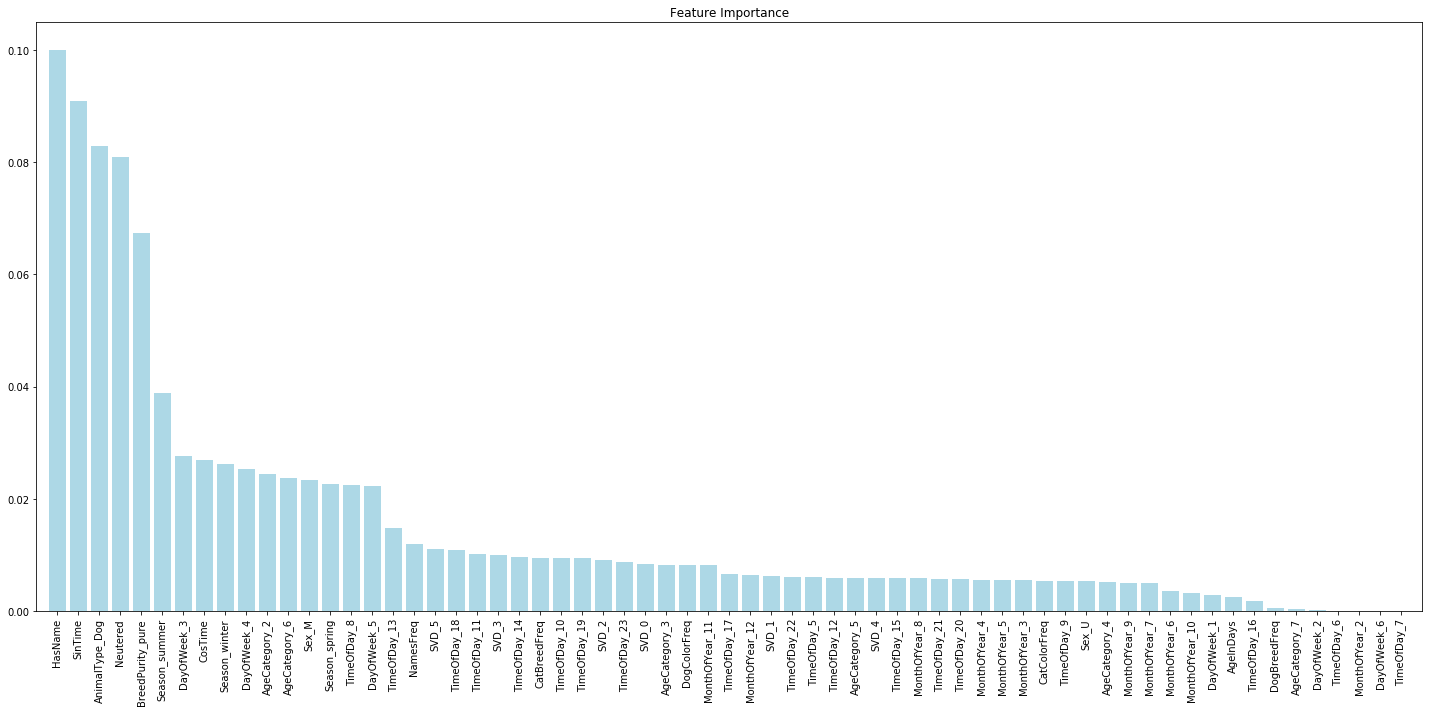

In [46]:
# continued from above - see feature importances
rf_importances = pipe_rf.named_steps['clf'].feature_importances_

rf_indices = np.argsort(rf_importances)[::-1]
print expl_variables[rf_indices]

plot_feature_importance(rf_importances, rf_indices, len(expl_variables[indices_svd]), expl_variables)

# RF doen't rank SVD features as much as mutual information does.  Indeed performance suffers 
# when using RF with SVD features

In [47]:
# finally let's train the best performing model accompanied by the features on which it worked
# best.  Let's also increase the estimators to 1000.  No SVD.

pipe_best_rf = Pipeline([('min_max', MinMaxScaler()),
                    ('clf', RandomForestClassifier(random_state=22, n_estimators=1000))])

# get all features
model_df = get_features(df, mode=2)
# get set most suited for RF
X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, 'both', include_svd=False, components=20)
print expl_variables
scores = cross_val_score(pipe_best_rf, X_train, y_train, scoring='neg_log_loss', cv=3, verbose=True)
print "Cross val RF log loss: %.3f +/- %.3f" % (np.mean(scores), np.std(scores))


Index([u'HasName', u'Neutered', u'AgeInDays', u'SinMonth', u'CosMonth',
       u'SinTime', u'CosTime', u'AnimalType_Dog', u'Sex_M', u'Sex_U',
       u'BreedPurity_pure', u'DayOfWeek_1', u'DayOfWeek_2', u'DayOfWeek_3',
       u'DayOfWeek_4', u'DayOfWeek_5', u'DayOfWeek_6', u'NamesFreq',
       u'DogBreedFreq', u'CatBreedFreq', u'DogColorFreq', u'CatColorFreq'],
      dtype='object')
Cross val RF log loss: -0.780 +/- 0.011


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


In [48]:
# continued from above - fit to get a useable model
pipe_best_rf.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('min_max', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=22, verbose=0, warm_start=False))])

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

       Adoption       0.70      0.84      0.76      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.69      0.19      0.29       156
Return_to_owner       0.50      0.37      0.43       479
       Transfer       0.74      0.77      0.75       939

    avg / total       0.67      0.69      0.66      2671

Confusion matrix, without normalization
[[901   0   2  87  87]
 [  2   0   2   1  15]
 [ 28   0  29  28  71]
 [212   0   2 179  86]
 [147   0   7  64 721]]


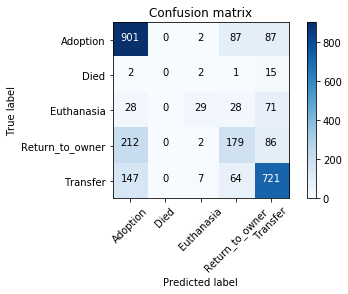

In [51]:
# let predict and product classification report and confusion matrix
y_pred = pipe_best_rf.predict(X_valid)
y_pred_prob = pipe_best_rf.predict_proba(X_valid)
f1 = f1_score(y_valid, y_pred, average='weighted') 
ll = log_loss(y_valid, y_pred_prob)

# print classification report
print(classification_report(y_valid, y_pred, target_names=classes))

# plot confusion matrix
cm = confusion_matrix(y_valid, y_pred)
plot_confusion_matrix(cm, classes)

# Export feature sets

In [ ]:
df_test = pd.read_csv('test.csv', header=0, sep=",")
df_test = df_test.pipe(extract_basic_features)
df_test
test_data = get_features(df_test, mode=3, drop_first=True )
test_data
df

# Export features set into csv
def export_df(feature_array, outcome_array, col_names, filename):
    temp_col = list(col_names) + ['Outcome']
    temp_df = pd.DataFrame(data=np.hstack((feature_array, outcome_array.reshape(1,-1).T)), 
                           index=np.arange(0, feature_array.shape[0]), 
                           columns=temp_col)
    temp_df.to_csv(filename, index=False)

model_frames = [get_features(df, mode=x) for x in [0,1]]
for i, model_df in enumerate(model_frames):
    X_train, X_valid, y_train, y_valid, expl_variables, classes = get_train_valid_sets(model_df, 'both', include_svd=False, components=20)
        
    #export_df(X_train, y_train, expl_variables, "train_jf_features_svd_"+str(i+2) + ".csv")
    #export_df(X_valid, y_valid, expl_variables, "valid_jf_features_svd_"+str(i+2) + ".csv")
    export_df(X_train, y_train, expl_variables, "train_jf_features_"+str(i) + ".csv")
    export_df(X_valid, y_valid, expl_variables, "valid_jf_features_"+str(i) + ".csv")

#pd.DataFrame(X_train, list(expl_variables))
#expl_variables[]

#resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
#resultsdf["ID"] = resultsdf["ID"].astype(int)
#resultsdf.to_csv("results3csv", index=False)
#resultsdf

# ScratchPad

In [ ]:
dt = datetime.now()

print dt.weekday()
print dt.month
print dt.hour
print dt.hour + round(dt.minute/60.0)
print dt.minute
print dt.second
seconds_in_day = 24*60*60
dt = (dt.hour * 3600) + (dt.minute * 60) + dt.second
# Monday = 0; Tue = 1; Wed = 2; Thurs = 3; Fri = 4; Sat = 5; Sun = 6


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def rand_times(n):
    """Generate n rows of random 24-hour times (seconds past midnight)"""
    rand_seconds = np.random.randint(0, 24*60*60, n)
    return pd.DataFrame(data=dict(seconds=rand_seconds))

n_rows = 1000

df = rand_times(n_rows)
# sort for the sake of graphing
df = df.sort_values('seconds').reset_index(drop=True)
df.head()

#df.seconds.plot();

seconds_in_day = 24*60*60

df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_in_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_in_day)

#df = df.drop(['seconds'], axis=1)

#df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

df.sin_time.plot();
print df.iloc[500,:]
df.cos_time.plot();

In [ ]:
['hello', 'world'] + ['james']
[x for x in ['hello', 'world', 'james'] if x not in ['james','world']]


In [ ]:
pd.__version__

a = np.array([[1,0,1],[0,10,15],[1,12,20],[1,-1,-10] ])

a[a[:,0]==0,:].shape